In [1]:
from typing import Sequence, Callable

import graphinference.libs.qspems_sim_core as qspems_sim_core
from graphinference import inference_methods, metrics

import matplotlib.pyplot as plt
import netrd
import networkx as nx
import numpy as np

# Inference Accuracy as Number of Observations Increase

In [2]:
def graph_inf_f1_score_as_obs_incr(
    num_obs_seq: Sequence[int],
    graph_model: Callable[[None], nx.Graph],
    dynamic_model: Callable[[nx.Graph, int], np.ndarray],
    infr_method: Callable[[np.ndarray], np.ndarray],
):
    """Measure the improvement of graph inference with more observations.
    
    Args:
        obs_seq: A sequence of integers representing the number of time
            points to sample.
        graph_model: A zero argument function that generates a network.
        dynamic_model: A two argument function that accepts a network
            and an integer and returns an (mxn) time series where
            m is the number of nodes in the graph and n is the number
            of observations.

    Returns:
        A sequence of F1 scores corresponding to `num_obs_seq` that
        denotes the effectiveness 
    """
    f1_scores = np.zeros(len(num_obs_seq))
    for i, n in enumerate(num_obs_seq):
        # Make a random graph
        G = graph_model()

        # Generate a stochastic time series of length n
        X = dynamic_model(G, n)
        # Retrieve and store F1 score
        pred_adj = infr_method(X)
        f1_scores[i] = metrics.compare_adj_f1_score(nx.to_numpy_array(G), pred_adj)

    return f1_scores


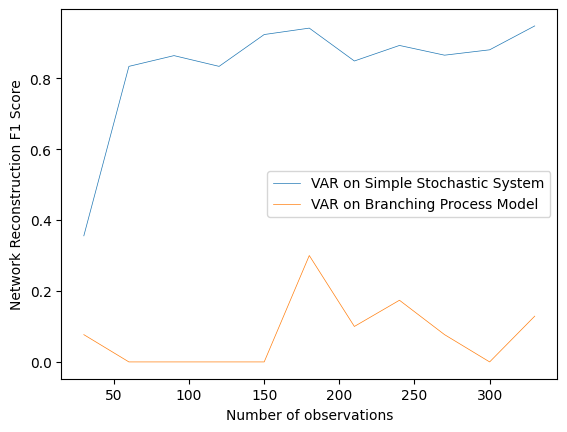

In [7]:
obs_seq = np.arange(30, 360, 30)


graph_model = lambda: nx.fast_gnp_random_graph(10, .2)
qspems_model = lambda G, n: qspems_sim_core.sim(nx.to_numpy_array(G).T, dt=1, T=n)
var_infr = lambda X: inference_methods.vector_autoregression(X)

f1_qs_var = graph_inf_f1_score_as_obs_incr(obs_seq, graph_model, qspems_model, var_infr)

# SIS model
branching_model_class = netrd.dynamics.BranchingModel()
initial_fraction_active = 0.5
branching_ratio = 0.9
desired_average_activity = 0.2


branch_model = lambda G, n: branching_model_class.simulate(
    G,
    n,
    initial_fraction=initial_fraction_active,
    m =branching_ratio,
    target_Ahat=desired_average_activity,
)
f1_branch_var = graph_inf_f1_score_as_obs_incr(obs_seq, graph_model, branch_model, var_infr)


plt.plot(obs_seq, f1_qs_var, lw=0.5, label="VAR on Simple Stochastic System")
plt.plot(obs_seq, f1_branch_var, lw=0.5, label="VAR on Branching Process Model")
plt.xlabel("Number of observations")
plt.ylabel("Network Reconstruction F1 Score")
plt.legend()
plt.show()
